# Bayes Networks

## Install required packages

In [1]:
#They take a while to install

#Uncomment if you are using colab
#!apt install libgraphviz-dev 

!pip3 install pomegranate --quiet
#!pip3 install pygraphviz  --quiet
!pip3 install pandas 
!pip3 install matplotlib


  ERROR: Command errored out with exit status 1:
   command: /home/thierens/anaconda3/envs/AIPractical2/bin/python3.8 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-0e4oc53i/pomegranate/setup.py'"'"'; __file__='"'"'/tmp/pip-install-0e4oc53i/pomegranate/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-0chqd1wv
       cwd: /tmp/pip-install-0e4oc53i/pomegranate/
  Complete output (456 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.8
  creating build/lib.linux-x86_64-3.8/pomegranate
  copying pomegranate/io.py -> build/lib.linux-x86_64-3.8/pomegranate
  copying pomegranate/callbacks.py -> build/lib.linux-x86_64-3.8/pomegranate
  copying pomegranate/__init__.py -> build/lib.linux-x86_64-3.8/pomegranate
  creating build/lib.linux-x86_64-3.

In [9]:
!pip3 install pandas 
!pip3 install matplotlib

## Libraries

In [2]:
from pomegranate import BayesianNetwork, DiscreteDistribution, Node, ConditionalProbabilityTable
from matplotlib.pyplot import figure
import pandas as pd
# Cosmetics
%config InlineBackend.figure_format ='retina'
pd.options.display.float_format = '{:,.3f}'.format
def print_df(array):
    print(pd.DataFrame(array).to_string(header=False,index = False))
    

## Helper Functions
We integrate the functionalities of the library with code below. 

In [3]:
#@title 

# Updates and plot the model and infers the conditional probability
def add_conditional_variable(variable_name,statistics,ordered_conditionals,
                             ordered_parents,distributions,nodes,model,plot=True):
    kopy = ordered_conditionals.copy()
    if variable_name not in distributions.keys():
        distribution = ConditionalProbabilityTable(
            explicit_probabilities(ordered_conditionals.copy()[variable_name]),
            [distributions[parent] for parent in ordered_parents[variable_name]]
            )
        distributions[variable_name] = distribution 
        node = Node(distribution, variable_name)
        nodes[variable_name] = node
        model.add_states(node)
        for parent in ordered_parents[variable_name]:
            model.add_edge(nodes[parent], node)   
    if plot:
        figure(dpi=160) 
        model.plot()
    model.bake()
    # Inferred probability of 'Y'
    inferred_probability = model.marginal()[-1].parameters[0]['Y']
    print(f'{variable_name}: \n\t Inferred probability = {inferred_probability:.3f}') 
    print( f'\t Statistic = {statistics[variable_name]}')
    assert kopy == ordered_conditionals

# Needed to explicitly state probabilities for Y and N
def explicit_probabilities(array):
    new_array = []
    for row in array:
        Y_row = row.copy()
        N_row = row.copy()
        Y_row.insert(-1, 'Y'),
        N_row.insert(-1, 'N'),
        N_row[-1] = 1 - row[-1]
        new_array.extend([Y_row,N_row])
    return new_array

# Helper function to increase readability
def print_predict_proba(model, nodes, obs_states, target=None):
    distrs = model.predict_proba([obs_states])[0]
    evidence = []
    uknown_distrs = []
    uknown_variables = []
    for name, state, distr in zip(nodes.keys(),obs_states,distrs):
        if state == 'Y':
            evidence.append(name)
        elif state == 'N':
            evidence.append('No_'+name)
        else:
            uknown_distrs.append(distr)
            uknown_variables.append(name)
    # We recapitulate the evidence and print the probabilities
    print(f'When C = {", ".join(evidence)}:')
    for name, distr in zip(uknown_variables,uknown_distrs):
        if not target or target == name:
            print(f'Prob({name}|C): {distr.parameters[0]["Y"]:.3f}')
    print()


## Inserting data from the medical report

In [21]:
# Fill in the following dictionary with the names of variables (keys) and their probabilities (values).
# Only two states per variable ('Y' and 'N'), shown probabilities for 'Y'.
# Variables with unknown statistic should be listed with value None
statistics = {'Weakened_immune': .053,
              'Smoking': .29,
               'Pneumonia': .018,
                'Lung cancer': .037,
                 'Bronchitis': 0.09,
                    'Common cold': .37,
                     'Fever': .085,
                        'Loose cough': .19,
                            'Chest pain': .14,
                                'Shortness of breath': .18,
                                    'Runny nose': None,
                                     'other': None}

# Update the following dictionary with the name of their dependecies to express the 
# Topology as a list of parent nodes
ordered_parents = {variable: [] for variable in statistics.keys()}
'''
ordered_parents.update({'Shortness of breath': ['Bronchitis', 'Lung cancer', 'Pneumonia', 'other'], 'Chest pain': ['Lung cancer', 'Pneumonia', 'other'],
                        'Fever':['Pneumonia','Common cold', 'other'], 'Runny nose':['Common cold', 'other'], 'Loose cough':['Bronchitis','Pneumonia','other'], 'Lung cancer':['Smoking', 'other'],
                       'Bronchitis':['Smoking','other'], 'Pneumonia':['Weakened immune systems', 'Lung cancer', 'other']})
'''
ordered_parents.update({'Shortness of breath': ['Bronchitis', 'Lung cancer', 'Pneumonia', 'other'], 'Chest pain': ['Lung cancer', 'Pneumonia', 'other'],
                        'Fever':['Pneumonia','Common cold', 'other'], 'Runny nose':['Common cold', 'other'], 'Loose cough':['Bronchitis','Pneumonia','other'], 'Lung cancer':['Smoking'],
                       'Bronchitis':['Smoking'], 'Pneumonia':['Weakened_immune', 'Lung cancer', 'other']})
# Fill in the following CPT table with the states of the ordered parents ('N','Y', None if not known)
# corresponding to the event P(X='Y'|parents(X)). The probabilies P(X='N'|parents(X)) 
# will be automatically calculated later on.
ordered_conditionals = { 'Effect': [['Y', .8],
                                      ['N',.6]]}
'''
ordered_conditionals = { 'Shortness of breath': [['Y', .8],['Y',.5],['Y', .5],['Y', .1]], 'Chest pain': [['Y', .9],['Y', .9],['Y', .10]],
                        'Loose cough': [['Y', .9],['Y', .9],['Y', .1]], 'Fever': [['Y', .94],['Y', .2], ['Y',.001]], 'Runny nose': [['Y', .95],['Y', .01]], 'Lung cancer': [['Y',.10],['Y',.01]],
                       'Bronchitis': [['Y',.30],['Y',.01]], 'Pneumonia': [['Y',.3],['Y',.05],['Y', .001]]} 
                       '''
ordered_conditionals = { 'Shortness of breath': [['Y', .8],['Y',.5],['Y', .5],['Y', .1]], 'Chest pain': [['Y', .9],['Y', .9],['Y', .10]],
                        'Loose cough': [['Y', .9],['Y', .9],['Y', .1]], 'Fever': [['Y', .94],['Y', .2], ['Y',.001]], 'Runny nose': [['Y', .95],['Y', .01]], 'Lung cancer': [['Y',.10]],
                        'Lung cancer': [['N',.01]], 'Bronchitis': [['Y',.30]], 'Bronchitis': [['N',.01]], 'Pneumonia': [['Y',.3],['Y',.05],['Y', .001]]} 

## Number of parameters

In [23]:
# Number of parameters required - complete CTP parameters
total_parameters = 0
for variable, parents in ordered_parents.items():
    amount_of_parents = len(parents)
    total_parameters += 2**amount_of_parents
print(' Total number of parameters:', total_parameters)

 Total number of parameters: 60


## Draw the topology

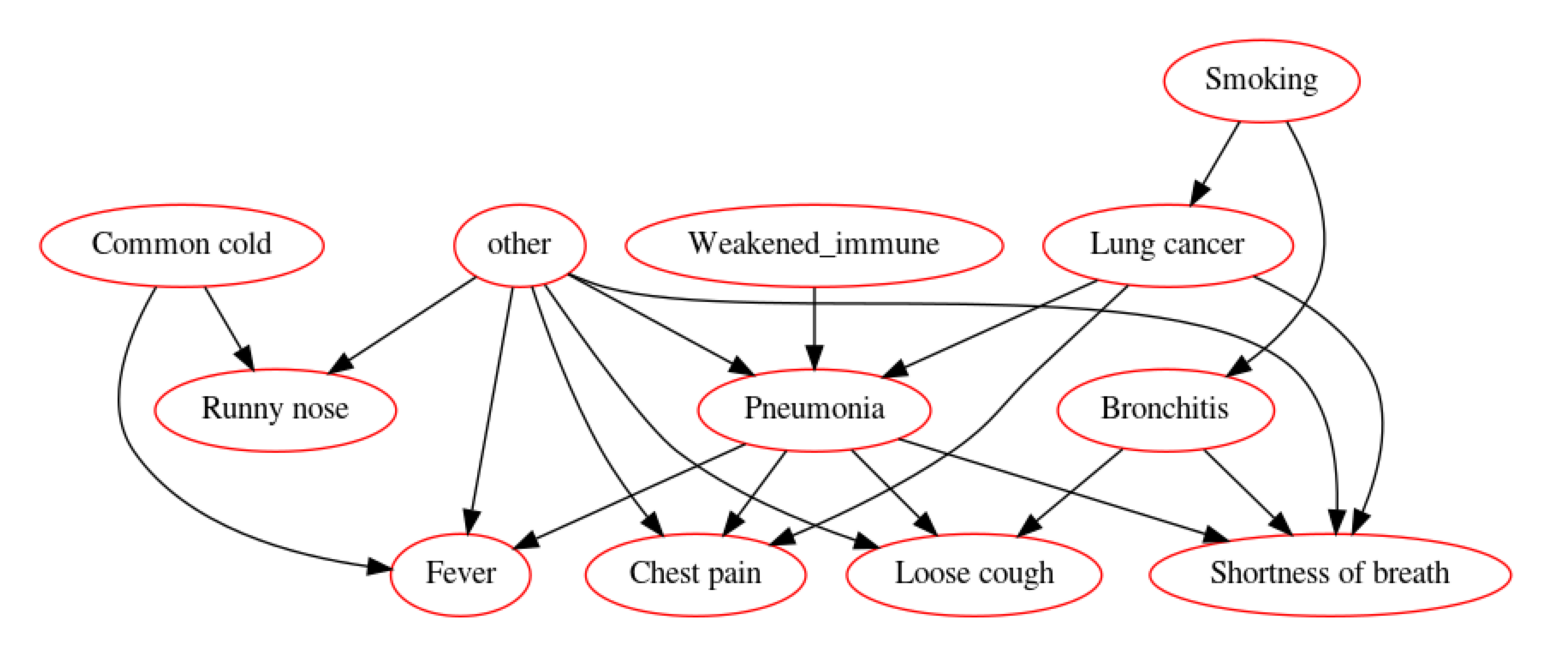

In [22]:
import pygraphviz
# We sketch a dummy model only to see the graph
sketch_model = BayesianNetwork("Medical Report - sketch")

# Topology expressed with edges 
edges = []
for variable_name, parents in ordered_parents.items():
    for parent in parents:
        edge = [parent, variable_name]
        edges.append(edge)
        
# Dummy variables
nodes = {}
for variable_name in statistics.keys():
    distribution = DiscreteDistribution({'Y': .5, 'N': .5})
    node = Node(distribution, name=variable_name)
    nodes[variable_name] = node
    
# Add States    
sketch_model.add_states(*nodes.values())

# Add Edges
for edge in edges:
    sketch_model.add_edge(nodes[edge[0]], nodes[edge[1]])
    
# Plot
figure(dpi=160)
sketch_model.plot()

## Belief propagation

In [68]:
# Let us initialize the real model
model = BayesianNetwork("Medical Report")

# Topology expressed as list of children
ordered_children = {variable: [] for variable in statistics.keys()}
for edge in edges:
    ordered_children[edge[0]].append(edge[1])

# Independent variables and leaves
independent_variables = [variable for variable, parents in ordered_parents.items() if not parents]
leaves = [variable for variable, children in ordered_children.items() if not children]
print(independent_variables)
# Write a function that lists the variables in stages so that the dependencies of a variable 
# are always coming from a previous stage  
def propagate_net(independent_variables,leaves,ordered_parents):
    belief_propagation_test = []
    belief_propagation_test.append(independent_variables)
    #search for the children of the first and add them in the next stage
    i = len(independent_variables)
    incorporated = independent_variables
    while i < len(ordered_parents):
        temp_nex_stage = []
        for variable in ordered_parents:
            for parent in ordered_parents[variable]:
                add_to_stage = False
                for stage in belief_propagation_test:
                    if parent in stage:
                        add_to_stage = True
                if not add_to_stage:
                    break
            print("variable passed", variable)
        
            if variable not in incorporated:
                temp_nex_stage.append(variable)
                incorporated.append(variable)
        break
        i += 1
        print(temp_nex_stage)
        belief_propagation_test.append(temp_nex_stage)
        print("append")
    '''
    while True:
        end_of_net = True
        temp_next_stage = []
        temp_parents = set(belief_propagation_test[i])
        for variable in ordered_parents:
            if temp_parents & set(ordered_parents[variable]): 
                if variable not in temp_next_stage:
                    temp_next_stage.append(variable)
                    end_of_net = False

        if end_of_net:
            break
        belief_propagation_test.append(temp_next_stage)
        i += 1
    '''
    belief_propagation = belief_propagation_test
    return belief_propagation

# Check the previous graph to see how at every stage, all the parents are already known
belief_propagation = propagate_net(independent_variables,leaves,ordered_parents)
for stage, variables in enumerate(belief_propagation):
    print(f' {stage+1}) {", ".join(variables)}')

['Weakened_immune', 'Smoking', 'Common cold', 'other']
variable passed Weakened_immune
variable passed Smoking
variable passed Pneumonia
variable passed Lung cancer
variable passed Bronchitis
variable passed Common cold
variable passed Fever
variable passed Loose cough
variable passed Chest pain
variable passed Shortness of breath
variable passed Runny nose
variable passed other
 1) Weakened_immune, Smoking, Common cold, other, Pneumonia, Lung cancer, Bronchitis, Fever, Loose cough, Chest pain, Shortness of breath, Runny nose


## Independent variables

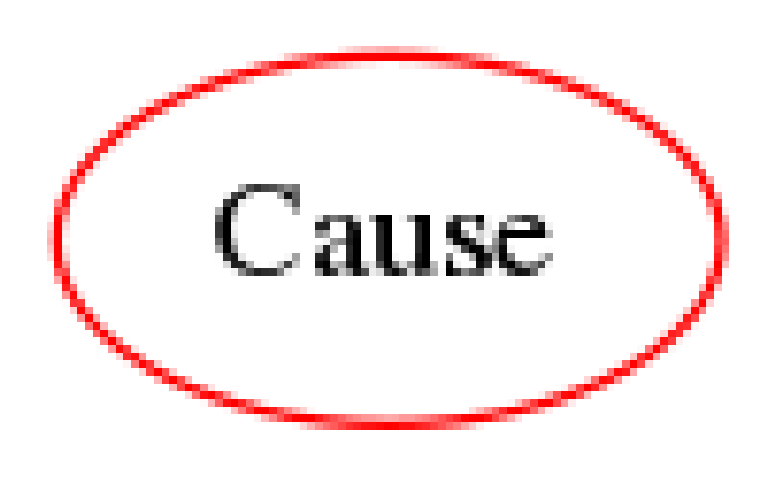

In [8]:
# We add variables following the order above
distributions = {}
nodes = {}
for variable_name in independent_variables:
    probability = statistics[variable_name]
    distribution = DiscreteDistribution({'Y': probability, 'N': 1 - probability})
    node = Node(distribution, name=variable_name)
    distributions[variable_name] = distribution
    nodes[variable_name] = node
    
model.add_states(*nodes.values())
figure(dpi=80)
model.plot()

args = [statistics,ordered_conditionals,ordered_parents,distributions,nodes,model]

## Infer the conditional probabilities

Effect: 
	 Inferred probability = 0.700
	 Statistic = 0.7


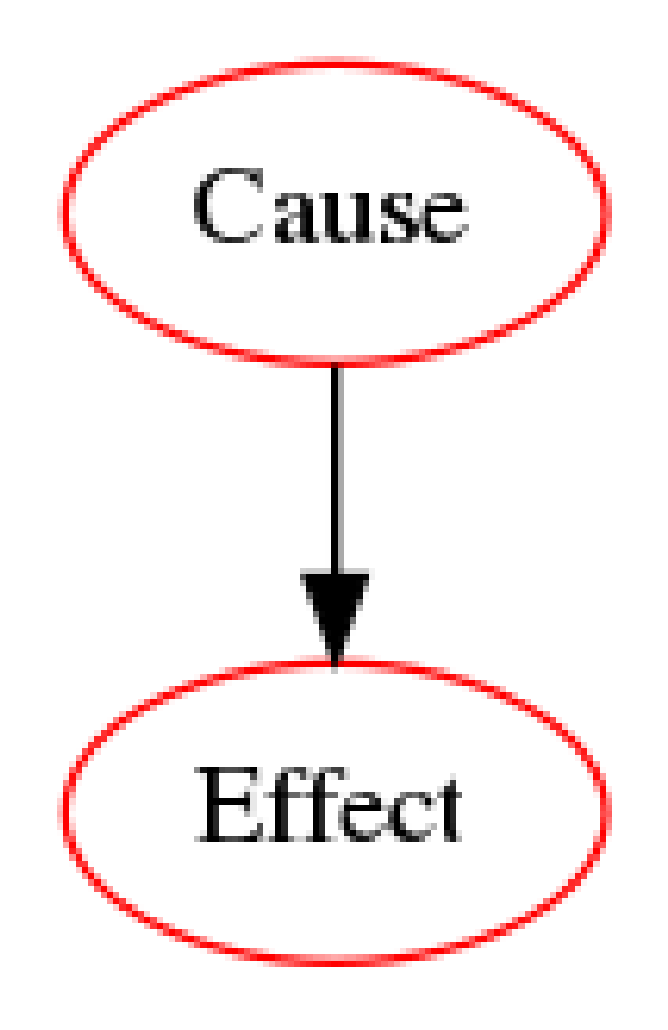

In [9]:
# We add the variable to the model and check that the statistics are consistent
add_conditional_variable('Effect',*args,plot=True)

# If you are using colab you can use tabs to add sequentially more variables 

# from google.colab import widgets
# tab_variables = ['example2']
# tb = widgets.TabBar([str(i) for i in range(len(tab_variables))])
# for i, variable_name in enumerate(tab_variables):
#   with tb.output_to(i, select=(i < 1)):
#     add_conditional_variable(variable_name,*args)


In [10]:
# To make the code more readable you can name the indices of the variables
node_list = list(nodes.keys())
Cause_index = node_list.index('Cause')
Effect_index = node_list.index('Effect')


## Cause -> Effect
P(Cause = 'Y'| Effect = 'Y')


In [11]:
# We create a vector of known and unknown states 
obs_states = [None]*len(node_list)
obs_states[Cause_index] = 'Y'

# We calculate the inferenced probabilities 
# (None target lists the probabilities of all the non observed variable)
print_predict_proba(model, nodes, obs_states, target='Effect')   

When C = Cause:
Prob(Effect|C): 0.800

